In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [2]:
import pandas as pd
import numpy as np

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding,Activation,Flatten,merge,TimeDistributed,CuDNNGRU,Bidirectional
from keras.layers.merge import concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import concatenate,subtract,add,maximum,multiply,Layer,Lambda
from keras.backend import backend as K

from tqdm import tqdm


Using TensorFlow backend.


In [3]:
## read data from path
MAX_SEQUENCE_LENGTH = 40
MAX_NB_WORDS = 4000000
nrows = 10000000
EMBEDDING_DIM = 300

# nrows = 10000
train = pd.read_csv("./train.csv",nrows=nrows).astype(str)
test = pd.read_csv("./test.csv",nrows=nrows).astype(str)

In [4]:
train.head(10)

id qid1 qid2                                          question1  \
0  0    1    2  What is the step by step guide to invest in sh...   
1  1    3    4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2  2    5    6  How can I increase the speed of my internet co...   
3  3    7    8  Why am I mentally very lonely? How can I solve...   
4  4    9   10  Which one dissolve in water quikly sugar, salt...   
5  5   11   12  Astrology: I am a Capricorn Sun Cap moon and c...   
6  6   13   14                                Should I buy tiago?   
7  7   15   16                     How can I be a good geologist?   
8  8   17   18                    When do you use シ instead of し?   
9  9   19   20  Motorola (company): Can I hack my Charter Moto...   

                                           question2 is_duplicate  
0  What is the step by step guide to invest in sh...            0  
1  What would happen if the Indian government sto...            0  
2  How can Internet speed be increased by hacking...            0  
3  Find the remainder when [math]23^{24}[/math] i...            0  
4            Which fish would survive in salt water?            0  
5  I'm a triple Capricorn (Sun, Moon and ascendan...            1  
6  What keeps childern active and far from phone ...            0  
7          What should I do to be a great geologist?            1  
8              When do you use "&" instead of "and"?            0  
9  How do I hack Motorola DCX3400 for free internet?            0

In [5]:
## generate keras inputs
## tokenizer and padding
corpus = []

feats = ['question1','question2']
for f in feats:
    train[f] = train[f].astype(str)
    test[f] = test[f].astype(str)
    corpus+=train[f].values.tolist()
    
    
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(corpus)
X_q1 = tokenizer.texts_to_sequences(train['question1'])
X_q2 = tokenizer.texts_to_sequences(train['question2'])

X_test_q1 = tokenizer.texts_to_sequences(test['question1'])
X_test_q2 = tokenizer.texts_to_sequences(test['question2'])


X_q1 = pad_sequences(X_q1, maxlen=MAX_SEQUENCE_LENGTH)
X_q2 = pad_sequences(X_q2, maxlen=MAX_SEQUENCE_LENGTH)
X_test_q1 = pad_sequences(X_test_q1, maxlen=MAX_SEQUENCE_LENGTH)
X_test_q2 = pad_sequences(X_test_q2, maxlen=MAX_SEQUENCE_LENGTH)

y = train['is_duplicate'].values

word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))
nb_words = min(MAX_NB_WORDS, len(word_index))+1


Found 95596 unique tokens


## question 
    how to use pretrained embedding like glove,word2vec

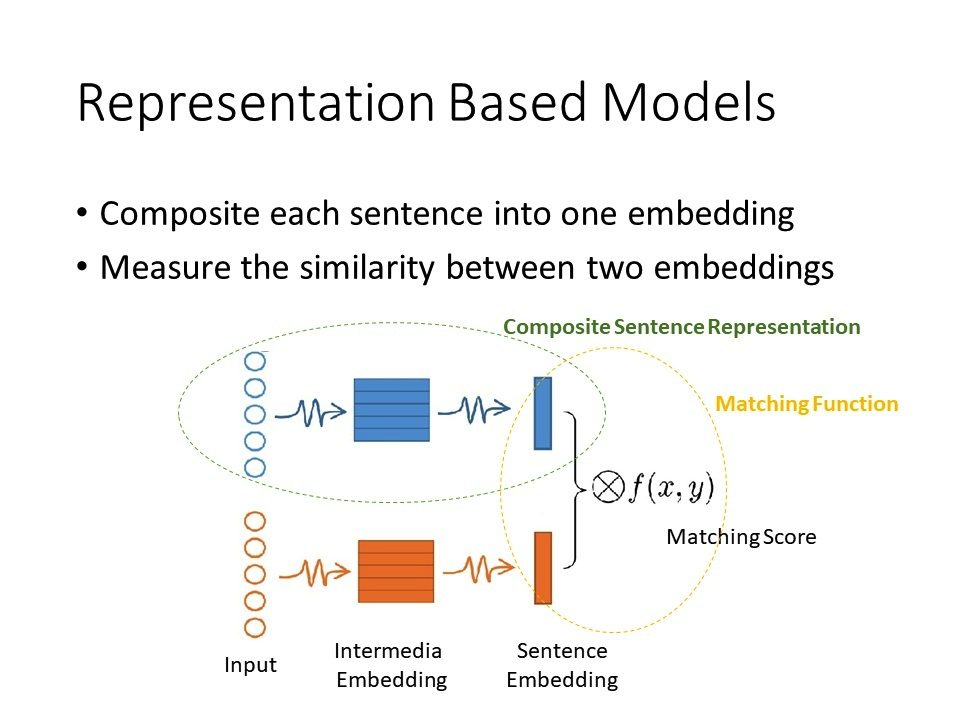


In [6]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')

def load_embeddings(path):
    with open(path) as f:
        return dict(get_coefs(*line.strip().split(' ')) for line in tqdm(f))

def build_matrix(word_index, path):
    embedding_index = load_embeddings(path)
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    unknown_words = []
    
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_index[word]
        except KeyError:
            unknown_words.append(word)
    return embedding_matrix, unknown_words

# 一个单词，300维度的向量
glove_path = './glove.840B.300d.txt'
embedding_matrix,unknown_words = build_matrix(word_index,glove_path)

2196018it [05:37, 6512.26it/s]


In [7]:
## eval metric is logloss
from sklearn.metrics import log_loss

In [8]:
## validation set
from sklearn.model_selection import train_test_split
X_train_q1,X_val_q1,X_train_q2,X_val_q2,y_train,y_val = train_test_split(X_q1,X_q2,y,train_size=0.8,random_state=1024)
print(X_train_q1.shape,X_val_q1.shape)
X_train = [X_train_q1,X_train_q2]
X_val = [X_val_q1,X_val_q2]
X_test = [X_test_q1,X_test_q2]


(323432, 40) (80858, 40)


In [9]:
def get_model_siamese(nb_words=50000,MAX_SEQUENCE_LENGTH=200,EMBEDDING_DIM=200,act='relu',embedding_matrix=None):
    ########################################
    ## define the model structure
    ########################################
    
    input_q1 = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    input_q2 = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

    if embedding_matrix is not None:
        weights=[embedding_matrix],

        embedding_layer = Embedding(nb_words,
                EMBEDDING_DIM,
                input_length=MAX_SEQUENCE_LENGTH,
                weights=[embedding_matrix],
                trainable=False)
    else:
        embedding_layer = Embedding(nb_words,
                EMBEDDING_DIM,
                input_length=MAX_SEQUENCE_LENGTH,
                trainable=True)

    # 200 -》 200 * 300
    embedded_sequences_q1 = embedding_layer(input_q1)
    embedded_sequences_q2 = embedding_layer(input_q2)
    
    bilstm_layer = Bidirectional(CuDNNGRU(64,return_sequences=False))

    
    x1 = bilstm_layer(embedded_sequences_q1)
    x2 = bilstm_layer(embedded_sequences_q2)

    
    diff = subtract([x1,x2])
    summation = add([x1,x2])
    # dot(x1 )
    
    x = concatenate([x1,x2,diff,summation],1)

    x = Dense(64,activation=act)(x)
    
    preds = Dense(1,activation='sigmoid')(x)


    model = Model(inputs=[input_q1,input_q2],outputs=preds)
    model.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])
    print(model.summary())
    
    return model

In [10]:
## train model

early_stopping =EarlyStopping(monitor='val_loss', patience=5)
bst_model_path = 'best_model.h5'
model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)

model = get_model_siamese(nb_words=nb_words,MAX_SEQUENCE_LENGTH=MAX_SEQUENCE_LENGTH,EMBEDDING_DIM=EMBEDDING_DIM,act='relu',embedding_matrix=embedding_matrix)
model.fit(X_train,y_train,epochs=250,validation_data=(X_val, y_val),batch_size=128,shuffle=True,verbose=1,callbacks=[early_stopping, model_checkpoint])

model.load_weights(bst_model_path)


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 40, 300)      28679100    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 128)          140544      embedding_1[0][0]          

In [11]:
## make submission 
y_pred_test = model.predict(X_test)

submission = pd.DataFrame()
submission['test_id'] = test['test_id']
submission['is_duplicate'] = y_pred_test
submission.to_csv('submission_siamese.csv',index=False)
